In [1]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
from mmdet.apis import init_detector
import numpy as np
import cv2
import mmdet
import mmyolo
import os
from evaluation_utils import *


print('mmcv', mmcv.__version__)
print('mmengine', mmengine.__version__)
print('mmdet', mmdet.__version__)
print('mmyolo', mmyolo.__version__)
%pwd

/data1/anaconda3/envs/mmyolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data1/anaconda3/envs/mmyolo/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data1/anaconda3/envs/mmyolo/lib/python3.10/site-packages/torc

mmcv 2.0.1
mmengine 0.10.4
mmdet 3.3.0
mmyolo 0.6.0


'/data1/zhengyj/mmyolo'

#### Test Set up

In [2]:
img_dir = './datasets/beluga/images'
ann_test_sam = './datasets/beluga/annotations/split_sam_BUF_7/test.json'
ann_test_box = './datasets/beluga/annotations/split_box_BUF_7/test.json'

annotation_sam, name2index_sam = get_annotation(ann_test_sam)
annotation_box, name2index_box = get_annotation(ann_test_box)

img_names = []
for image in annotation_sam['images']:
    img_names.append(image['file_name'])

In [ ]:
det_config_file = './configs_beluga/yolov8_s_b24-100e.py'
det_checkpoint_file_sam = './checkpoints/YOLO-SAM.pth'
det_checkpoint_file_box = './checkpoints/YOLO-Buffer.pth'

det_model_sam = init_detector(det_config_file, det_checkpoint_file_sam)
det_model_sam.cfg['model']['test_cfg']['score_thr'] = 0.15

det_model_box = init_detector(det_config_file, det_checkpoint_file_box)
det_model_box.cfg['model']['test_cfg']['score_thr'] = 0.37

inter_class_nms_thr = 0.4

#### Visualize single model

/data1/anaconda3/envs/mmyolo/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


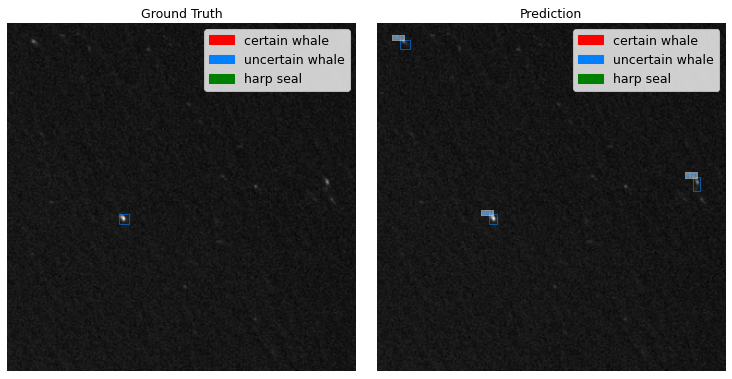

----------


In [4]:
det_model = det_model_sam

for cnt, filename in enumerate(img_names):
    gt_bboxes, gt_labels = get_gt_box(annotation_sam, name2index_sam, filename)    # gt_labels begin with 0
    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path)
    bboxes, scores, labels = detect(det_model, img, inter_class_nms_thr=inter_class_nms_thr)
    # print(f'No. {cnt}', filename, f'\n pred box {bboxes}\n', f'gt box {gt_bboxes}\n', f'pred_label{labels}\n', f'gt label{gt_labels}')
    visulize_predictions(img, bboxes, gt_bboxes, labels, gt_labels, scores, dpi=75)
    print('-'*10)
    break

#### Compare two models

----------


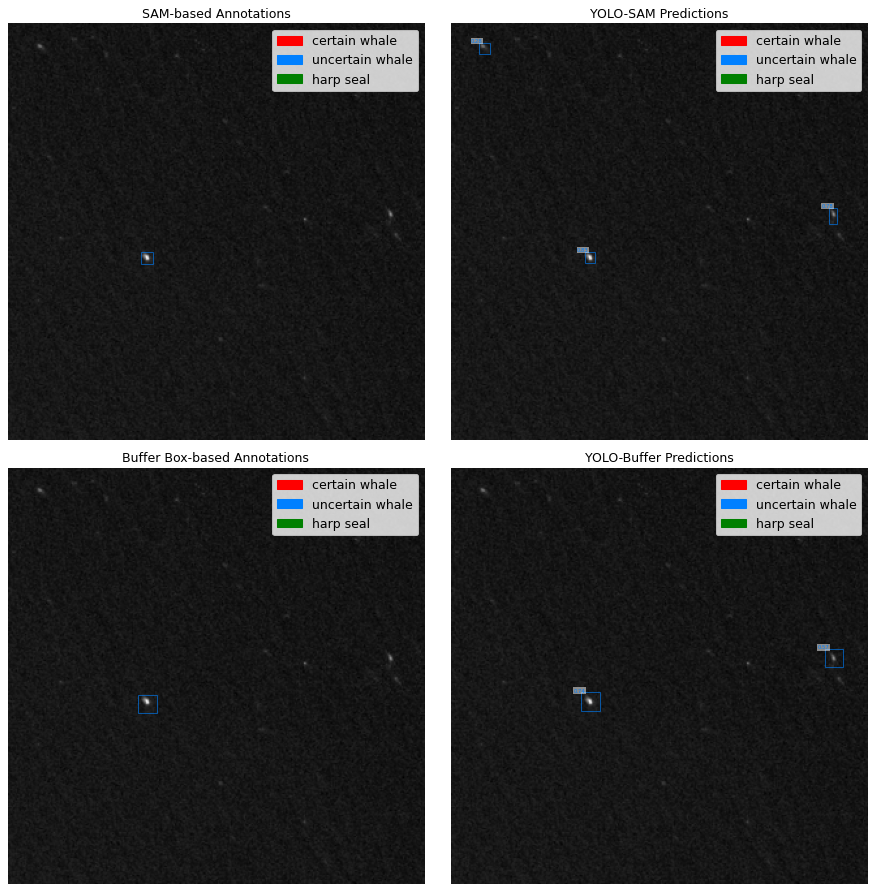

In [5]:
for cnt, filename in enumerate(img_names):
    gt_bboxes_sam, gt_labels_sam = get_gt_box(annotation_sam, name2index_sam, filename)    # gt_labels begin with 0
    gt_bboxes_box, gt_labels_box = get_gt_box(annotation_box, name2index_box, filename)    # gt_labels begin with 0

    img_path = os.path.join(img_dir, filename)
    img = cv2.imread(img_path)
    bboxes_sam, scores_sam, labels_sam = detect(det_model_sam, img, inter_class_nms_thr=inter_class_nms_thr)
    bboxes_box, scores_box, labels_box = detect(det_model_box, img, inter_class_nms_thr=inter_class_nms_thr)

    # print(f'No. {cnt}', filename, f'gt box {gt_bboxes_sam}\n', f'gt label{gt_labels_sam}')
    visualize_comparison(img, gt_bboxes_sam, gt_labels_sam, bboxes_sam, labels_sam, scores_sam,
                         gt_bboxes_box, gt_labels_box, bboxes_box, labels_box, scores_box,
                         filename=filename, show_plot=False, dpi=75)
    print('-'*10)
    break

### Performance Metrics

#### evaluate coco mAP

In [6]:
det_model = det_model_sam
det_model_sam.cfg['model']['test_cfg']['score_thr'] = 0.001
evaluate_model(det_model, ann_test_sam, img_dir, inter_class_nms_thr=0.4)

det_model = det_model_box
det_model_box.cfg['model']['test_cfg']['score_thr'] = 0.001
evaluate_model(det_model, ann_test_box, img_dir, inter_class_nms_thr=0.4)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.322
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

#### Precision and Recall under different confidence thresholds

In [ ]:
det_model = det_model_sam
ann_test = ann_test_sam
x_values = np.arange(0.1, 0.5, 0.01)

avg_precisions, avg_recalls, avg_f1s = [], [], []
for confidence in x_values:
    det_model.cfg['model']['test_cfg']['score_thr'] = confidence
    coco_gt, coco_results = evaluate_model(
        det_model, ann_test, img_dir, inter_class_nms_thr=inter_class_nms_thr, return_result=True)
    confusion_mat = compute_confusion_matrix(
        coco_gt, coco_results, iou_thr=0.25, num_classes=3)
    avg_precision, avg_recall, avg_f1 = calculate_precision_recall(
        confusion_mat, class_names, metrix_class="certain whale")
    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1s.append(avg_f1)

max f1: 0.674
max precision: 0.705
max recall: 0.645
confidence: 0.15


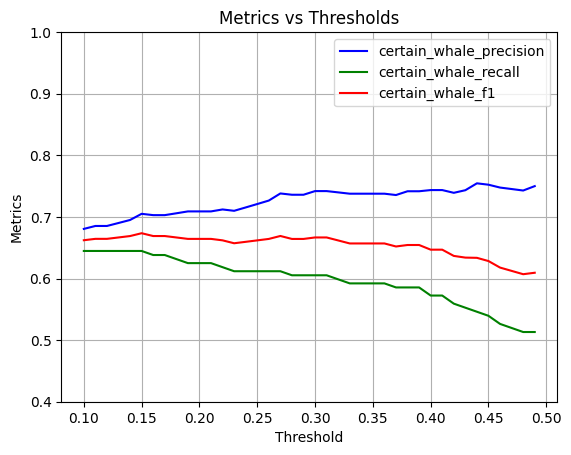

In [8]:
print('max f1:', f'{max(avg_f1s):.3f}')
print('max precision:', f'{avg_precisions[np.argmax(avg_f1s)]:.3f}')
print('max recall:', f'{avg_recalls[np.argmax(avg_f1s)]:.3f}')
print('confidence:', f'{x_values[np.argmax(avg_f1s)]:.2f}')

# Plot each line with a different color
plt.plot(x_values, avg_precisions, color='blue',
         label='certain_whale_precision')
plt.plot(x_values, avg_recalls, color='green', label='certain_whale_recall')
plt.plot(x_values, avg_f1s, color='red', label='certain_whale_f1')
plt.ylim(0.4, 1)

# Add title, labels, and legend
plt.title('Metrics vs Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend(loc='best')

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
det_model = det_model_sam
ann_test = ann_test_sam
x_values = np.arange(0.1, 0.5, 0.01)

avg_precisions, avg_recalls, avg_f1s = [], [], []
for confidence in x_values:
    det_model.cfg['model']['test_cfg']['score_thr'] = confidence
    coco_gt, coco_results = evaluate_model(
        det_model, ann_test, img_dir, inter_class_nms_thr=inter_class_nms_thr, return_result=True)
    confusion_mat = compute_confusion_matrix(
        coco_gt, coco_results, iou_thr=0.25, num_classes=3)
    confusion_mat = combine_whale_categories(confusion_mat)
    # print(new_confusion_matrix)
    avg_precision, avg_recall, avg_f1 = calculate_precision_recall(
        confusion_mat, ['whale', 'seal'], 'certain whale')
    avg_precisions.append(avg_precision)
    avg_recalls.append(avg_recall)
    avg_f1s.append(avg_f1)

max f1: 0.769
max precision: 0.856
max recall: 0.699
confidence: 0.25


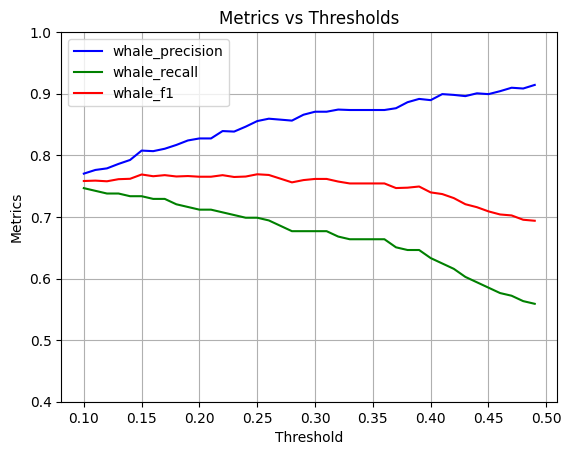

In [10]:
print('max f1:', f'{max(avg_f1s):.3f}')
print('max precision:', f'{avg_precisions[np.argmax(avg_f1s)]:.3f}')
print('max recall:', f'{avg_recalls[np.argmax(avg_f1s)]:.3f}')
print('confidence:', f'{x_values[np.argmax(avg_f1s)]:.2f}')

plt.plot(x_values, avg_precisions, color='blue', label='whale_precision')
plt.plot(x_values, avg_recalls, color='green', label='whale_recall')
plt.plot(x_values, avg_f1s, color='red', label='whale_f1')
plt.ylim(0.4, 1)
plt.title('Metrics vs Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### Confusion Matrix

In [11]:
confidence = 0.15
ann_test = ann_test_sam
det_model = det_model_sam
det_model.cfg['model']['test_cfg']['score_thr'] = confidence
coco_gt, coco_results = evaluate_model(
    det_model, ann_test, img_dir, inter_class_nms_thr=inter_class_nms_thr, return_result=True)
confusion_mat = compute_confusion_matrix(
    coco_gt, coco_results, iou_thr=0.25, num_classes=3)
calculate_precision_recall(confusion_mat, class_names, metrix_class="all")
print(confusion_mat)
new_confusion_matrix = combine_whale_categories(confusion_mat)
print(new_confusion_matrix)
combined_confusion_mat = calculate_precision_recall(
    new_confusion_matrix, ['whale', 'seal'], 'certain whale')
combined_confusion_mat

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Category-wise Precision and Recall:

Class 'certain whale': Precision = 0.7050, Recall = 0.6447 F1 Score = 0.6735
Class 'uncertain whale': Precision = 0.4638, Recall = 0.4156 F1 Score = 0.4384
Class 'harp seal': Precision = 0.6434, Recall = 0.8737 F1 Score = 0.7411

Overall Performance:
Average Precision: 0.6041
Average Recall: 0.6447
Average F1 Score: 0.6177
[[98 13 15 26]
 [25 32  0 20]
 [ 0  0 83 12]
 [16 24 31  0]]
[[168  15  46]
 [  0  83  12]
 [ 40  31   0]]
Category-wise Precision and Recall:



(0.8076923076923077, 0.7336244541484717, 0.768878718535469)

In [12]:
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)

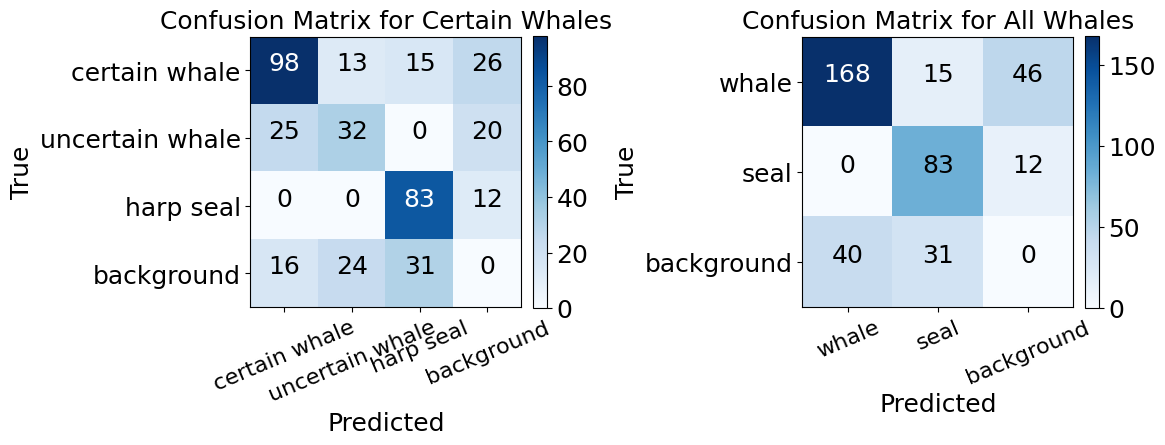

In [13]:
labels1 = ['certain whale', 'uncertain whale', 'harp seal', 'background']
labels2 = ['whale', 'seal', 'background']


def plot_confusion_matrix(cm, labels, title=None):
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    if title:
        plt.title(title)

    cbar = plt.colorbar(fraction=0.046, pad=0.04)  # 使用 fraction 和 pad 控制长度和位置

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=23)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 添加数字
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_mat, labels1,
                      title='Confusion Matrix for Certain Whales')
plt.subplot(1, 2, 2)
plot_confusion_matrix(new_confusion_matrix, labels2,
                      'Confusion Matrix for All Whales')
plt.tight_layout()
# plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

#### F1 score for all categories

In [14]:
def calculate_f1_for_all(confusion_mat, class_names):
    """
    Calculate F1 scores for each class and return them.

    Args:
        confusion_mat (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """

    num_classes = len(class_names)

    # Initialize F1 score list
    f1_scores = []

    print("Category-wise F1 Scores:\n")
    for i in range(num_classes):
        # True Positives (TP) for class i
        tp = confusion_mat[i, i]

        # False Positives (FP) for class i: Sum of column i excluding TP
        fp = np.sum(confusion_mat[:, i]) - tp

        # False Negatives (FN) for class i: Sum of row i excluding TP
        fn = np.sum(confusion_mat[i, :]) - tp

        # Precision: TP / (TP + FP)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0

        # Recall: TP / (TP + FN)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)

        # Print F1 score for this category
        print(f"Class '{class_names[i]}': F1 Score = {f1:.4f}")

    avg_f1 = np.mean(f1_scores)
    print(f"\nOverall Average F1 Score: {avg_f1:.4f}")
    f1_scores.append(avg_f1)
    
    return f1_scores

In [ ]:
ann_test = ann_test_sam
det_model = det_model_sam
x_values = np.arange(0.01, 0.99, 0.01)

f1_scores_list = {class_name: [] for class_name in ['whale overall', 'certain whale', 'uncertain whale', 'harp seal', 'all classes']}

# whale_overall
for confidence in x_values:
    det_model.cfg['model']['test_cfg']['score_thr'] = confidence
    coco_gt, coco_results = evaluate_model(det_model, ann_test, img_dir, inter_class_nms_thr=inter_class_nms_thr, return_result=True)
    
    confusion_mat = compute_confusion_matrix(coco_gt, coco_results, iou_thr=0.25, num_classes=3)
    f1_scores = calculate_f1_for_all(confusion_mat, class_names)
    
    confusion_mat = combine_whale_categories(confusion_mat)
    f1_scores_whale_overall = calculate_f1_for_all(confusion_mat, ['whale', 'seal'])

    f1_scores_list['whale overall'].append(f1_scores_whale_overall[0])
    for i, class_name in enumerate(['certain whale', 'uncertain whale', 'harp seal', 'all classes']):
        f1_scores_list[class_name].append(f1_scores[i])

In [16]:
f1_scores_list.pop('all classes', None);

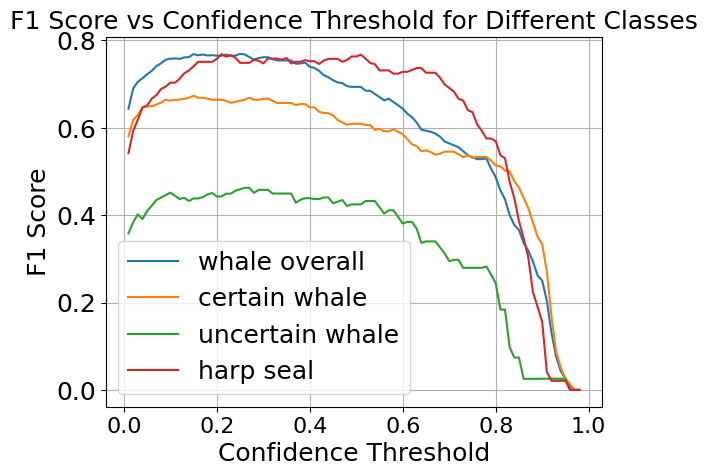

In [17]:
for class_name, f1_scores in f1_scores_list.items():
    plt.plot(x_values, f1_scores, label=f'{class_name}')

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence Threshold for Different Classes')
plt.legend()
plt.grid()
plt.show()